## <i>ENGG67 - ANÁLISE E PRÉ-PROCESSAMENTO DE DADOS</i>
**Universidade Federal da Bahia** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Semestre:** 2024.2 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Data:** 06/02/2025  
**Disciplina:** ENGG67 - Tópicos Especiais em Engenharia da Computação &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
**Docente:** Antonio C. L. Fernandes Jr. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Integrantes:** David Oliveira e André Costa  

**4° AVALIAÇÃO:**  
Utilizando o banco de dados **[Breast Cancer Wisconsin](https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original)**, aborde o problema de classificação utilizando o algoritmo k-NN. Lembre-se de analisar o dataset e avaliar a máquina de aprendizado com todas as medidas e gráficos apresentados em sala.

Este notebook aborda a implementação de um modelo de **K-Nearest Neighbors (KNN)** para a classificação de tumores malignos e benignos. O fluxo do trabalho inclui análise dos dados, pré-processamento, divisão em conjuntos de treino e teste, validação cruzada para avaliação robusta do modelo, análise de desempenho no conjunto de teste e, por fim, a visualização dos resultados obtidos.


In [9]:
# Importando bibliotecas pertinentes:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
import seaborn as sns
from utils import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn import tree

**Análise do conjunto de dados**  
Vamos aproveitar os códigos desenvolvidos na primeira atividade para realizar uma análise rápida sobre o conjunto de dados escolhido para esta avaliação. Abordaremos, por exemplo, o número de atributos preditivos e rótulos presentes, os valores existentes em cada atributo, a presença de objetos com atributos ausentes, a existência de objetos duplicados, presença de outliers entre outros aspectos. A seguir, detalharemos esses pontos:

LISTA DOS ATRIBUTOS DO CONJUNTO DE DADOS: ['Clump_thickness', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape', 'Marginal_adhesion', 'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin', 'Normal_nucleoli', 'Mitoses']
QUANTIDADE DE ATRIBUTOS PREDITIVOS DO CONJUNTO DE DADOS: (699, 9)
QUANTIDADE DE RÓTULOS DO CONJUNTO DE DADOS: (699, 1)

TODOS OS VALORES ENCONTRADOS PARA CADA ATRIBUTO:
CLUMP_THICKNESS: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
UNIFORMITY_OF_CELL_SIZE: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
UNIFORMITY_OF_CELL_SHAPE: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
MARGINAL_ADHESION: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
SINGLE_EPITHELIAL_CELL_SIZE: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
BARE_NUCLEI: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
BLAND_CHROMATIN: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
NORMAL_N

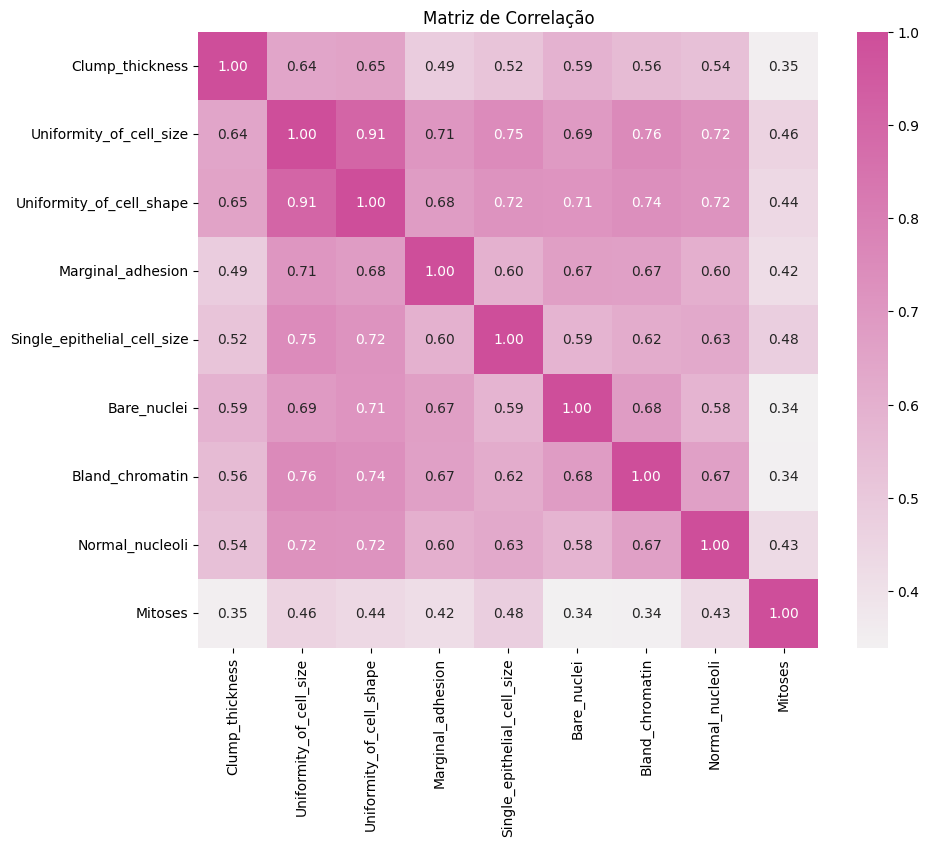

In [10]:
# Acessando os atributos do conjunto de dados seguinte as orientações do UCI.
breastCancer = fetch_ucirepo(id=15) 
x, y = breastCancer.data.features, breastCancer.data.targets
  
# Exibir informações do conjunto de dados, lembrando que teremos 303 instâncias ou objetos.
printColorido("LISTA DOS ATRIBUTOS DO CONJUNTO DE DADOS:".upper(), "magenta", " ")
print(list(x.columns))
printColorido("QUANTIDADE DE ATRIBUTOS PREDITIVOS DO CONJUNTO DE DADOS:", "magenta", ' ')
print(x.shape)
printColorido("QUANTIDADE DE RÓTULOS DO CONJUNTO DE DADOS:", "magenta", ' ')
print(y.shape)

# Podemos iterar sobre cada um dos objetos e coletar todos os valores possiveis dos atributos, para ajudar a caracterizar cada atributo.
printColorido("\nTODOS OS VALORES ENCONTRADOS PARA CADA ATRIBUTO:".upper(), "magenta")
valoresPossiveis = obterTodosValoresPossiveis(x, y)
for atributo, valores in valoresPossiveis.items(): # Exibindo os valores possíveis para cada atributo.
    printColorido(f"{atributo.upper()}: ", "yellow", end="")
    print(valores)

# Verificando o balanceamento das classes
classes = contarClasses(y) # Retorna um dicionario com a contagem do número classes.
printColorido("\nDistribuição das classes dos rótulos inicialmente:".upper(), "magenta")
printColorido(f"BENIGNO: ", "green", "")
print(classes[2], end="    ")
printColorido(f"MALIGNO: ", "red", "")
print(classes[4])

printColorido("\nVISUALIZAÇÃO DOS OBJETOS COM INCOMPLETUDE:".upper(), "magenta")
incompletos = obterIncompletude(x) # Procura, e exibe, quantos dados estão faltando.

printColorido("\nVISUALIZAÇÃO DOS OBJETOS COM REPETIÇÕES:".upper(), "magenta")
duplicados = obterRedundancias(x) # Encontrar as linhas duplicadas.

# Estatísticas do conjunto.
printColorido("\nESTATÍSTICAS DOS CONJUNTO DE DADOS:".upper(), "magenta")
for atributo in list(x.columns):
    array = x[atributo].values
    array = array[~np.isnan(array)]
    freq = obterFrequenciaPorAtributo(array)
    media, mediana, moda = np.mean(array), np.median(array), stats.mode(array, keepdims=True).mode[0]
    desvioPadrao, q1, q3 = np.std(array, ddof=1), np.percentile(array, 25), np.percentile(array, 75)
    obliquidade, curtose = stats.skew(array), stats.kurtosis(array) # Obliquidade (skewness) e Curtose.
    printColorido(f"{atributo.upper()}:", "magenta", "   ")
    printColorido("MÉDIA: ", "yellow", "")
    print(f"{round(media, 2)}", end="   ")
    printColorido("MEDIANA: ", "yellow", "")
    print(f"{round(mediana, 2)}", end="   ")
    printColorido("MODA: ", "yellow", "")
    print(f"{round(moda, 2)}", end="   ")
    printColorido("DESVIO PADRÃO: ", "yellow", "")
    print(f"{round(desvioPadrao, 2)}", end="   ")
    printColorido("Q1: ", "yellow", "")
    print(f"{round(q1, 2)}", end="   ")
    printColorido("Q3: ", "yellow", "")
    print(f"{round(q3, 2)}", end="   ")
    printColorido("OBLIQUIDADE: ", "yellow", "")
    print(f"{round(obliquidade, 3)}", end="   ")
    printColorido("CURTOSE: ", "yellow", "")
    print(f"{round(curtose, 3)}")
    
    

# Obtendo a matriz de correlação.
printColorido("\nVISUALIZAÇÃO DA MATRIZ DE CORRELAÇÃO:".upper(), "magenta")
correlacao = x.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap=sns.light_palette("#CE4E9A", as_cmap=True), fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


**Tratamento do conjunto de dados**

Após uma análise preliminar do conjunto de dados, realizamos um tratamento simples. Nesse processo, substituímos os valores ausentes pela mediana da respectiva coluna onde os valores vazios foram identificados. Além disso, eliminamos os valores redundantes, que, por sua vez, representam uma parcela significativa dos dados. Por fim, podemos verificar e eliminar a presença de objetos com outliers.

Outliers são valores que se encontram significativamente distantes da maioria dos outros dados em um conjunto. Eles podem ocorrer devido a erros de medição, falhas na coleta de dados ou representações extremas de um fenômeno. Em muitos casos, outliers podem distorcer a análise de dados e influenciar modelos preditivos, levando a resultados imprecisos ou enviesados. A identificação e remoção de outliers são práticas importantes para garantir a qualidade dos dados e a precisão das análises.

Uma forma comum de identificar outliers é utilizando o **Intervalo Interquartílico (IQR)**. O IQR é uma medida de dispersão que descreve a distância entre o primeiro quartil (Q1) e o terceiro quartil (Q3) de um conjunto de dados. Para identificar outliers, calculamos o IQR e, a partir dele, definimos limites superiores e inferiores que são expandidos 1,5 vezes para cada lado. Valores que ficam fora desses limites são considerados outliers. Exemplo de identificação de outliers utilizando o IQR:

In [11]:
# Realizando limpeza dos dados.
x = x.apply(lambda col: col.fillna(int(col.median())), axis=0)
excluidos = duplicados # + incompletos 
x, y = x.drop(excluidos, axis=0), y.drop(excluidos, axis=0)

# Exibindo a nova distribuição sem duplicados.
classes = contarClasses(y) # Retorna um dicionario com a contagem do número classes.
printColorido("\nDistribuição das classes dos rótulos sem duplicados:".upper(), "magenta")
printColorido(f"BENIGNO: ", "green", "")
print(classes[2], end="    ")
printColorido(f"MALIGNO: ", "red", "")
print(classes[4])

# Q1, Q3 = x.quantile(0.25), x.quantile(0.75)
# IQR = Q3 - Q1
# limInf, limSup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR # Definir os limites inferior e superior
# outliers = (x < limInf) | (x > limSup)

# x, y = x[~outliers.any(axis=1)], y[~outliers.any(axis=1)] # Remover linhas com outliers

# # Exibindo a nova distribuição.
# classes = contarClasses(y) # Retorna um dicionario com a contagem do número classes.
# printColorido("\nDistribuição das classes dos rótulos sem outliers:".upper(), "magenta")
# printColorido(f"BENIGNO: ", "green", "")
# print(classes[2], end="    ")
# printColorido(f"MALIGNO: ", "red", "")
# print(classes[4])


DISTRIBUIÇÃO DAS CLASSES DOS RÓTULOS SEM DUPLICADOS:
BENIGNO: 225    MALIGNO: 238



**Padronização**:  

A normalização por padronização é uma técnica essencial no pré-processamento de dados, especialmente quando lidamos com variáveis em diferentes escalas ou unidades. A padronização transforma os dados para que tenham uma média igual a zero e um desvio padrão igual a um. Esse processo é fundamental para diversos algoritmos de aprendizado de máquina, que podem ser sensíveis às diferenças de escala entre as variáveis. Dito isso, teremos:
$$
\nu_{Novo} = \frac{\nu_{Atual} - \mu}{\sigma}
$$  
Onde:
- $\nu_{Atual}$ é o valor original do dado,
- $\nu_{Novo}$ é o valor padronizado,
- $\mu$ é a média dos dados,
- $\sigma$ é o desvio padrão dos dados.

A seguir, aplicaremos a transformação necessária.

In [12]:
# Aplicando Normalização por padronização.
scaler = StandardScaler()
xNorm = scaler.fit_transform(x)

**Análise de Componentes Principais (PCA)**  
A análise de componentes principais é uma técnica estatística utilizada para reduzir a dimensionalidade dos dados, mantendo a maior parte da variância. Neste item, utilizaremos PCA para gerar gráficos que ilustram a projeção dos dados no espaço de atributos. Isso permite uma visão mais generalizada dos conjunto de objetos que está sendo avaliado. Ele permite o agrupamento dos pacientes que mais se assemelham, quando levado em consideração que eles apresentaram para cada um dos atributos. Tais agrupamentos são baseados em componentes principais, construídos a partir da agregação de todos os atributos. Essa técnica, no entanto, possui a desvantagem de levar a perda dos valores originais dos atributos, o que pode torná-la desinteressante para determinados segmentos, nos quais os valores dos atributos são significativos.

O uso de PCA em um problema como este com 9 atributos preditivos ajuda a reduzir a dimensionalidade dos dados, minimizando o impacto da "maldição da dimensionalidade". Quando o número de atributos é alto, o espaço de busca se torna vasto, tornando mais difícil para os modelos aprenderem de forma eficaz e aumentando o risco de overfitting. O PCA projeta os dados em um novo espaço de menor dimensão, preservando as variâncias mais importantes, o que melhora a eficiência do modelo e pode aumentar sua performance ao lidar com dados de alta dimensão.


Vamos aplicar PCA com 2 dimensões e com 3 dimensões, como veremos a seguir:

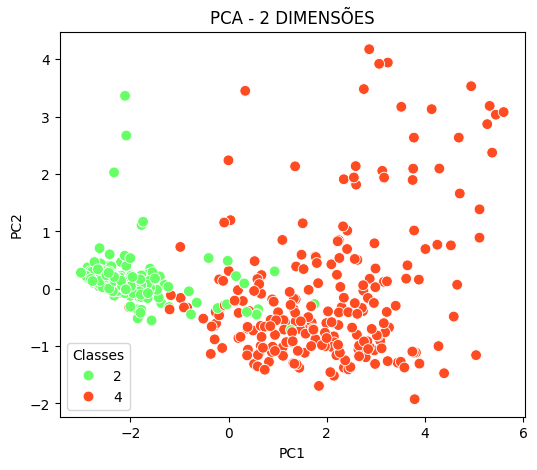

In [13]:
# Aplicando PCA para reduzir dimensionalidade.
pca2, pca3= PCA(n_components=2), PCA(n_components=3)
xPca2, xPca3= pca2.fit_transform(xNorm), pca3.fit_transform(xNorm)
y = y.values.ravel()

# Visualizar o PCA em 2D
plt.figure(figsize=(6, 5))
sns.scatterplot(x=xPca2[:, 0], y=xPca2[:, 1], hue=y, palette=["#66FF66", "#FF4B21"], s=60)
plt.title('PCA - 2 DIMENSÕES')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Classes', loc='best')
plt.show()

# # Criar gráfico 3D interativo
# fig = px.scatter_3d(
#     pd.DataFrame(xPca3, columns=["PC1", "PC2", "PC3"]),
#     x="PC1",
#     y="PC2",
#     z="PC3",
#     color=y.astype(str),
#     title="PCA - 3 DIMENSÕES",
#     labels={"Classe": "Classe"},
#     color_discrete_sequence=["#66FF66", "#FF4B21"],
# )
# fig.update_traces(marker=dict(size=5))
# fig.show()


**Criando a Árvore de Decisão**

Esse modelo pretende tomar decisões em relação a uma determinada variável do dataset pela forma bottom-up. Em cada célula desta árvore, ela faz perguntas de sim ou não ao dataset em relação aos atributos de um paciente em específico e seleciona para qual célula ele vai prosseguir, sendo sempre uma célula para o "sim" e outra para o "não", a partir da resposta obtida. 

Essas perguntas, no entanto, não são selecionadas de forma aleatória. Ele utiliza uma métrica chamada "Gin" que calcula as probabilidades da resposta ser sim ou não, e quanto mais próximos forem os valores dessas probabilidades, mais rapidamente essa pergunta levará a árvore a resposta final.

A árvore chega a sua última célula quando a pergunta dela levará com certeza ao rótulo final, independente da resposta.


MÉTRICAS MÉDIAS DOS CONJUNTOS DE VALIDAÇÃO USANDO VALIDAÇÃO CRUZADA:
ERRO TOTAL MÉDIO: 0.08 ± 0.01   ACURÁCIA MÉDIA: 0.92 ± 0.01   PRECISÃO MÉDIA: 0.92 ± 0.04   REVOCAÇÃO MÉDIA: 0.92 ± 0.04   PONTUAÇÃO F1 MÉDIA: 0.92 ± 0.01


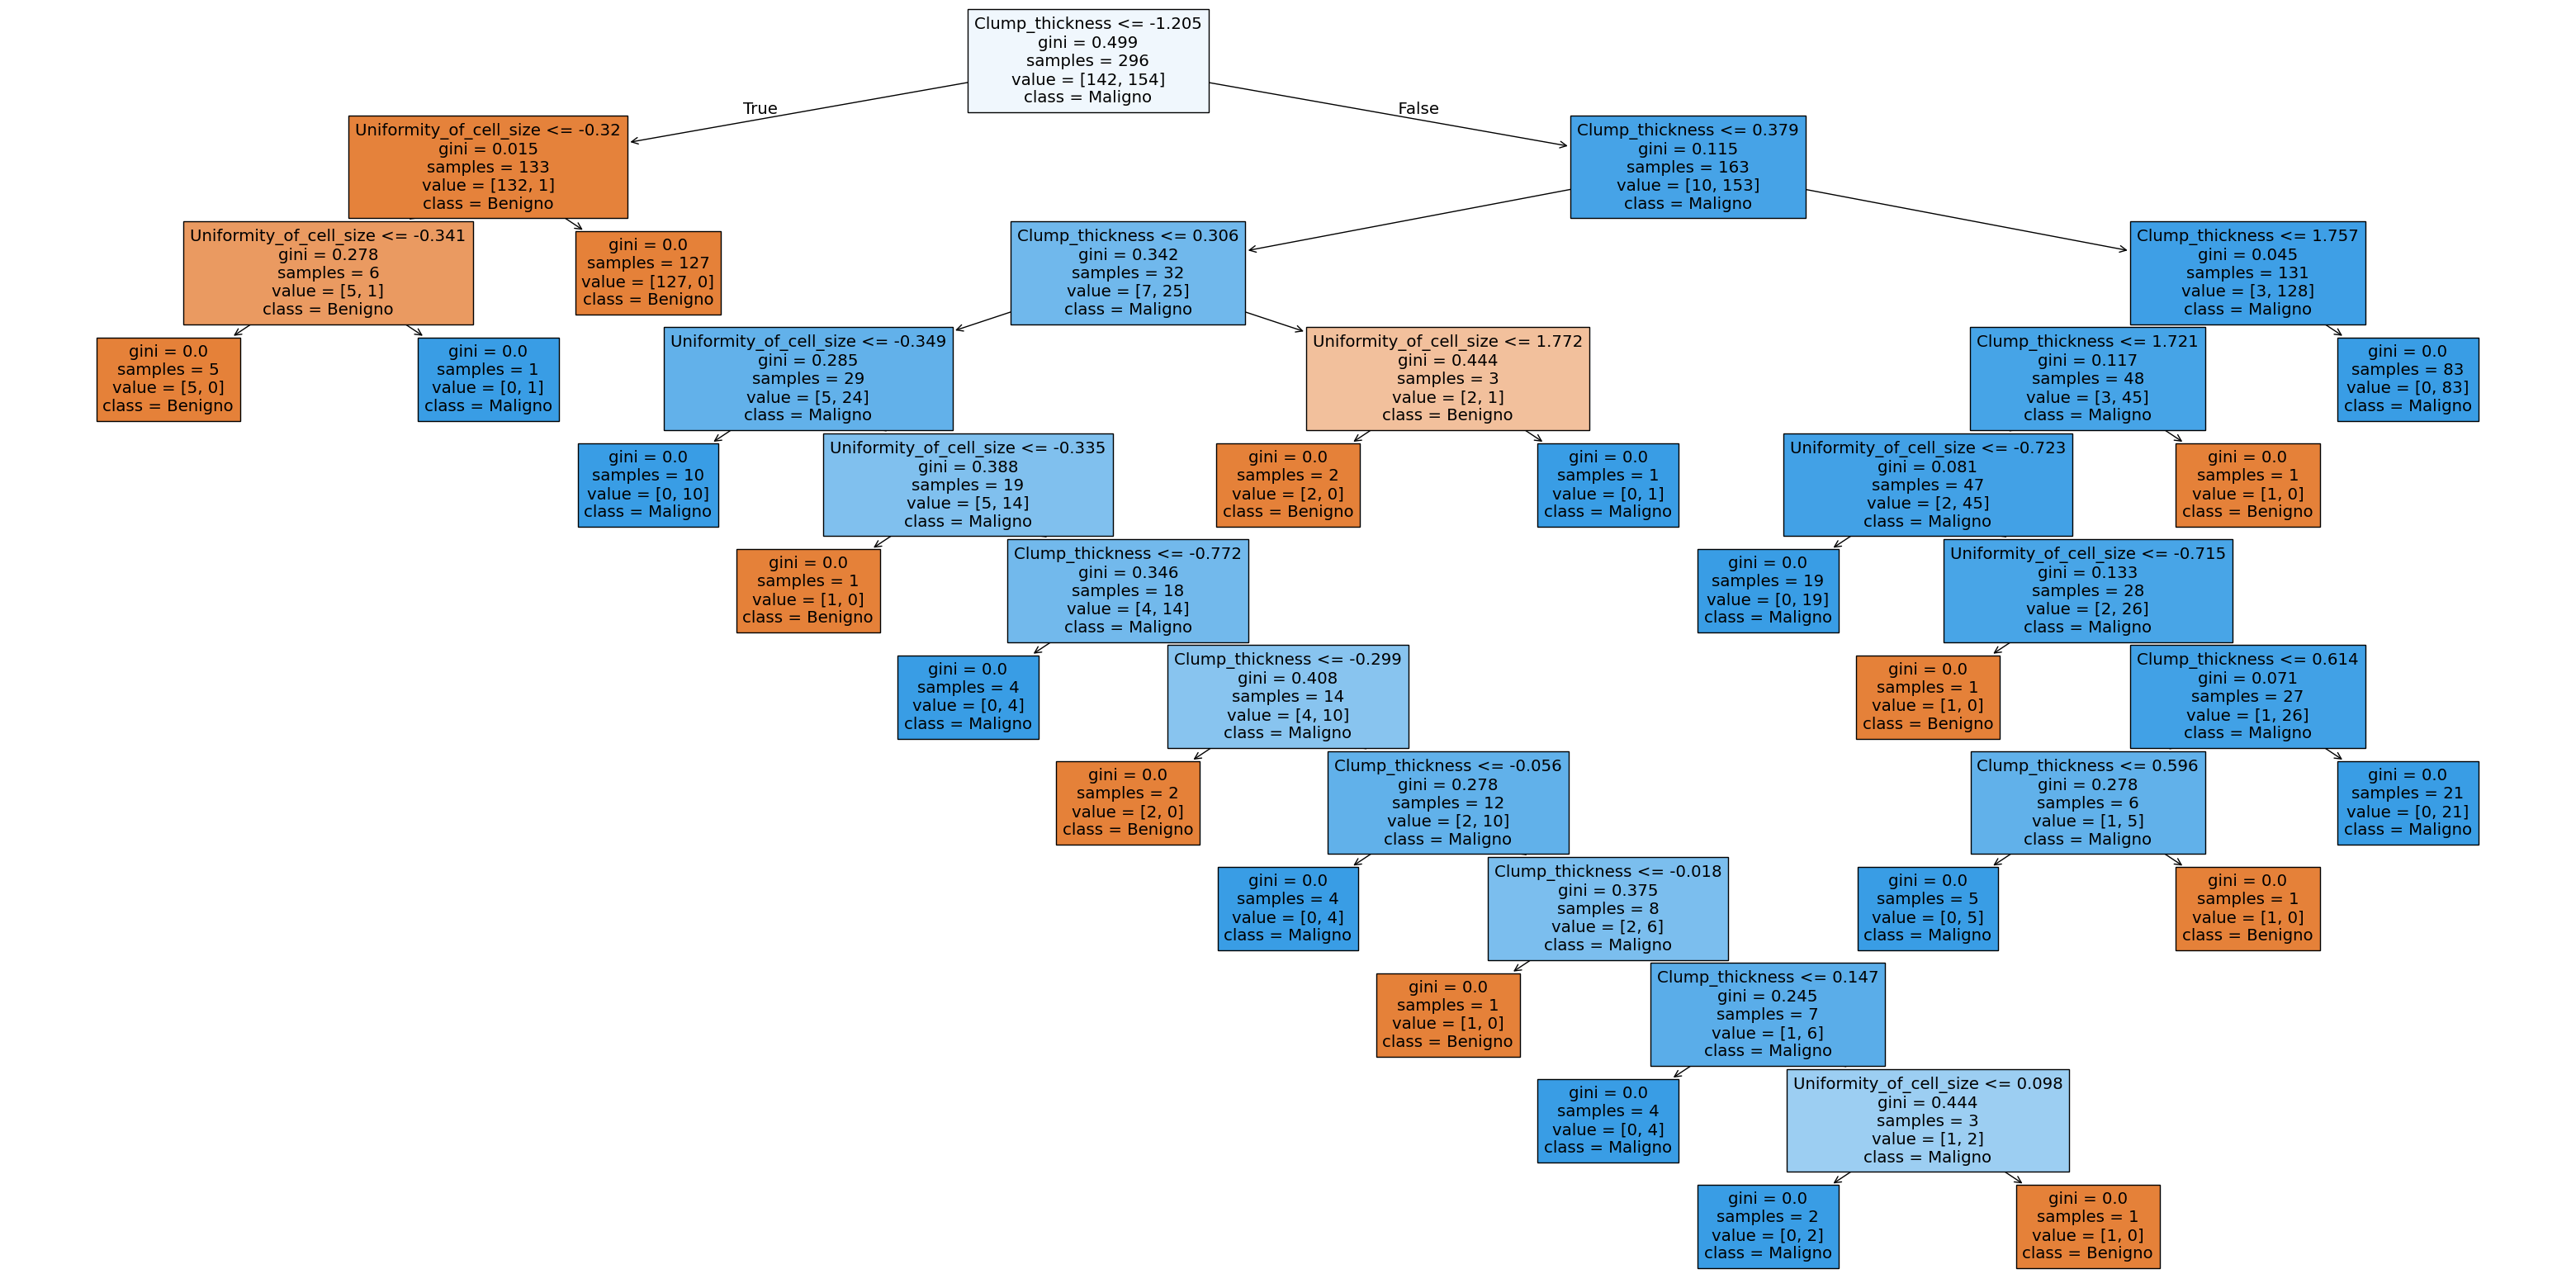

In [17]:
k, n = 5, 15 # Número de partições para validação cruzada e número de vizinhos, respectivamente.
yTransform = np.where(y == 2, 0, 1) # Atribui 1 para a classe 4 (maligno) e 0 para a classe 2 (benigno)
xPca = xPca2

# Divisão inicial dos dados em treino (80%) e teste (20%)
xTreino, xTeste, yTreino, yTeste = train_test_split(xPca, yTransform, test_size=0.2, random_state=42)

kf = KFold(n_splits=k, shuffle=True, random_state=42)

accList, precList, recallList, f1List, errList = [], [], [], [], [] # Listas para armazenar as métricas de cada fold
for treinamentoIndices, valIndices in kf.split(xTreino): # K-Fold Cross Validation
    
    # Dividindo os dados em treinamento e validação para cada fold.
    xTreinamento, xVal, yTreinamento, yVal = xPca[treinamentoIndices], xPca[valIndices], yTransform[treinamentoIndices], yTransform[valIndices]
    
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf.fit(xTreinamento, yTreinamento) # Treinar o modelo
    previsoes = clf.predict(xVal) # Fazer previsões

    # Obtendo matriz confusão e preparando calculo do erro total.
    cm = confusion_matrix(yVal, previsoes)
    FP, FN = cm[0, 1], cm[1, 0]
    
    # Calculando e armazenando as métricas
    errList.append((FP + FN) / cm.sum())
    accList.append(accuracy_score(yVal, previsoes))
    precList.append(precision_score(yVal, previsoes))
    recallList.append(recall_score(yVal, previsoes))
    f1List.append(f1_score(yVal, previsoes))

# Calcula a média e o desvio padrão das métricas para cada partição.
accMedia, accDesvio, precMedia, precDesvio = np.mean(accList), np.std(accList), np.mean(precList), np.std(precList)
recallMedia, recallDesvio, f1Media, f1Desvio= np.mean(recallList), np.std(recallList), np.mean(f1List), np.std(f1List)
errMedia, errDesvio = np.mean(errList), np.std(errList)

# Exibir os resultados
printColorido("\nMétricas médias dos conjuntos de validação usando validação cruzada:".upper(), "magenta")
printColorido("ERRO TOTAL MÉDIO: ", "yellow", "")
print(f"{errMedia:.2f} ± {errDesvio:.2f}", end="   ")
printColorido("ACURÁCIA MÉDIA: ", "yellow", "")
print(f"{accMedia:.2f} ± {accDesvio:.2f}", end="   ")
printColorido("PRECISÃO MÉDIA: ", "yellow", "")
print(f"{precMedia:.2f} ± {precDesvio:.2f}", end="   ")
printColorido("REVOCAÇÃO MÉDIA: ", "yellow", "")
print(f"{recallMedia:.2f} ± {recallDesvio:.2f}", end="   ")
printColorido("PONTUAÇÃO F1 MÉDIA: ", "yellow", "")
print(f"{f1Media:.2f} ± {f1Desvio:.2f}")

# Ajustar o tamanho da figura
plt.figure(figsize=(40, 20))  # Define um tamanho maior para melhor visualização

# Plotar a árvore de decisão
tree.plot_tree(clf, filled=True, feature_names=x.columns, class_names=["Benigno", "Maligno"])

# Mostrar o gráfico
plt.show()


MÉTRICAS NO CONJUNTO DE TESTE:
ERRO TOTAL: 0.01   ACURÁCIA: 0.99   PRECISÃO: 1.00   REVOCAÇÃO: 0.98   PONTUAÇÃO F1: 0.99   

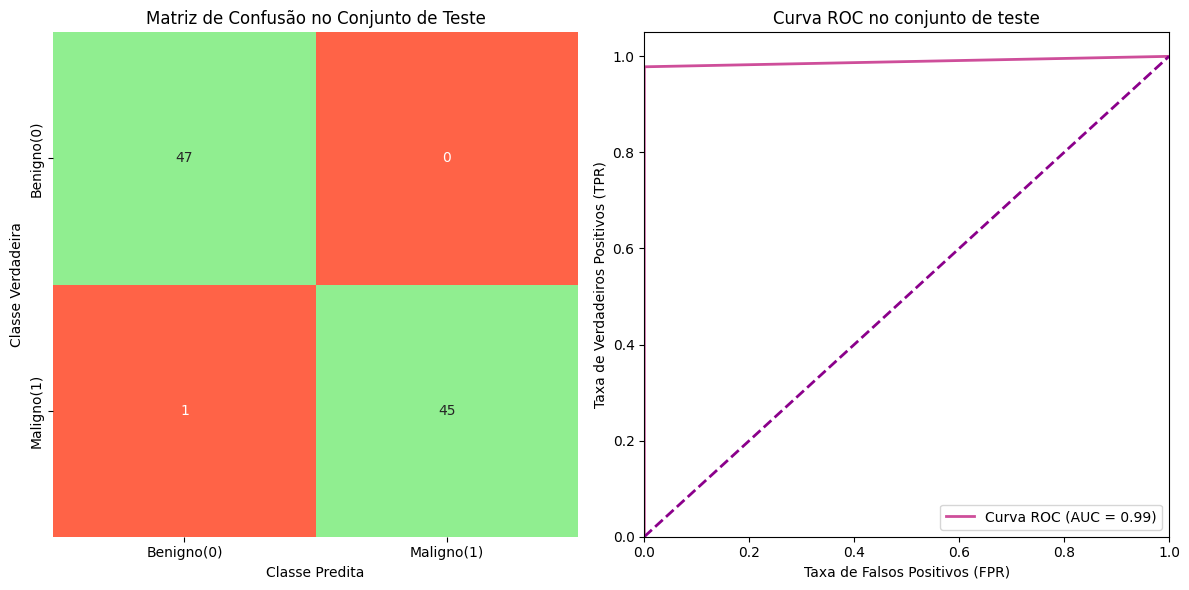

In [18]:
# Calcular métricas no conjunto de teste
previsoesTeste = clf.predict(xTeste)
cmTeste = confusion_matrix(yTeste, previsoesTeste) 
FPTeste, FNTeste  = cmTeste[0, 1], cmTeste[1, 0]
erroTotalTeste = (FPTeste + FNTeste) / cmTeste.sum()

# Calcular métricas no conjunto de teste
printColorido("\nMétricas no conjunto de teste:".upper(), "magenta")
printColorido("ERRO TOTAL: ", "yellow", "")
print(f"{erroTotalTeste:.2f}", end="   ")
printColorido("ACURÁCIA: ", "yellow", "")
print(f"{accuracy_score(yTeste, previsoesTeste):.2f}", end="   ")
printColorido("PRECISÃO: ", "yellow", "")
print(f"{precision_score(yTeste, previsoesTeste):.2f}", end="   ")
printColorido("REVOCAÇÃO: ", "yellow", "")
print(f"{recall_score(yTeste, previsoesTeste):.2f}", end="   ")
printColorido("PONTUAÇÃO F1: ", "yellow", "")
print(f"{f1_score(yTeste, previsoesTeste):.2f}", end="   ")

# Criando o subplot 1x2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot da matriz de confusão no conjunto de teste (primeiro gráfico)
sns.heatmap(cmTeste, annot=True, fmt="d", cmap=ListedColormap(["#FF6347", "#90EE90"]), 
            xticklabels=["Benigno(0)", "Maligno(1)"], yticklabels=["Benigno(0)", "Maligno(1)"], 
            cbar=False, ax=ax[0])
ax[0].set_title("Matriz de Confusão no Conjunto de Teste")
ax[0].set_xlabel("Classe Predita")
ax[0].set_ylabel("Classe Verdadeira")

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(yTeste, previsoesTeste)
aucTeste = auc(fpr, tpr)  # Calculando a AUC (Área sob a curva)

# Plotando a curva ROC no segundo gráfico
ax[1].plot(fpr, tpr, color="#CE4E9A", lw=2, label=f'Curva ROC (AUC = {aucTeste:.2f})')
ax[1].plot([0, 1], [0, 1], color="darkmagenta", lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('Taxa de Falsos Positivos (FPR)')
ax[1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
ax[1].set_title('Curva ROC no conjunto de teste')
ax[1].legend(loc='lower right')

# Ajustando o layout
plt.tight_layout()
plt.show()


MÉTRICAS NO CONJUNTO DE TESTE:
ACURÁCIA: 0.94   

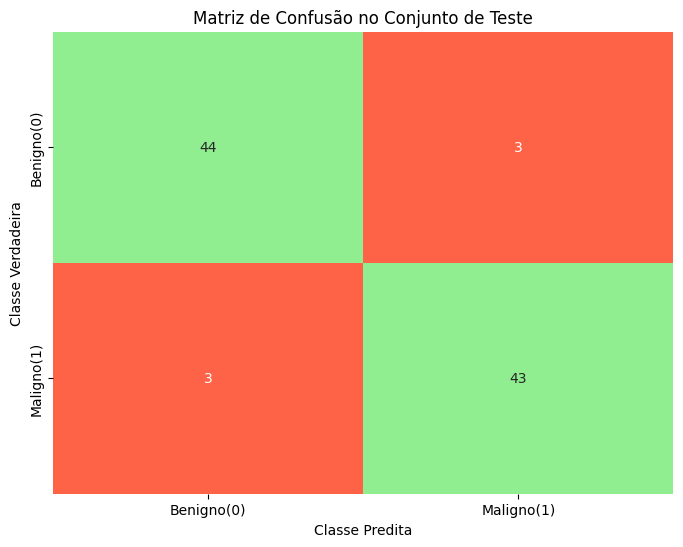

In [15]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calcular métricas no conjunto de teste
adTeste = confusion_matrix(y_test, y_pred)

# Calcular métricas no conjunto de teste
printColorido("\nMétricas no conjunto de teste:".upper(), "magenta")
printColorido("ACURÁCIA: ", "yellow", "")
print(f"{accuracy_score(y_test, y_pred):.2f}", end="   ")

# Criar a figura com tamanho adequado
plt.figure(figsize=(8, 6))

# Plot da matriz de confusão
sns.heatmap(adTeste, annot=True, fmt="d", cmap=ListedColormap(["#FF6347", "#90EE90"]), 
            xticklabels=["Benigno(0)", "Maligno(1)"], yticklabels=["Benigno(0)", "Maligno(1)"], 
            cbar=False)

# Adicionar título e rótulos
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Verdadeira")

# Mostrar o gráfico
plt.show()